In [34]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
import cv2
import h5py
import tensorflow as tf
import keras
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.xception import Xception
from keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib
from matplotlib import pylab, mlab
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize, getfigs
#from pylab import *
#from numpy import *
%matplotlib inline
import matplotlib.image as mpimg
from sklearn.utils import shuffle

In [10]:
pathToHistoriesC3 = '../../output/mobilenet_v2_a/breeder_01/data_C/Run_03/for_plots/histories_Run_03.pckl'
with open(pathToHistoriesC3, 'rb') as f:
    historiesC3 = pickle.load(f)
    f.close()
print(historiesC3)
print(historiesC3[0].history.keys())

[<keras.callbacks.History object at 0x10790e8d0>, <keras.callbacks.History object at 0xb4b3b25c0>, <keras.callbacks.History object at 0xb4b3b2b70>, <keras.callbacks.History object at 0xb4dbca2b0>]
dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


In [5]:
fileC1 = open("../../output/mobilenet_v2_a/breeder_01/data_C/Run_01/for_plots/histories_Run_01.pckl",'rb')
historiesC1 = pickle.load(fileC1)
fileC1.close()
histories = list(historiesC1)
print(histories)

['.', '.', '/', 'o', 'u', 't', 'p', 'u', 't', '/', 'm', 'o', 'b', 'i', 'l', 'e', 'n', 'e', 't', '_', 'v', '2', '_', 'a', '/', 'b', 'r', 'e', 'e', 'd', 'e', 'r', '_', '0', '1', '/', 'd', 'a', 't', 'a', '_', 'C', '/', '/', 'R', 'u', 'n', '_', '0', '1', '/', 'f', 'o', 'r', '_', 'p', 'l', 'o', 't', 's', '/', 'h', 'i', 's', 't', '.', 'h', 'i', 's', 't', 'o', 'r', 'i', 'e', 's']


history keys = dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])
len(histories) = 4


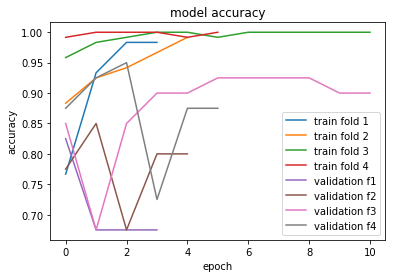

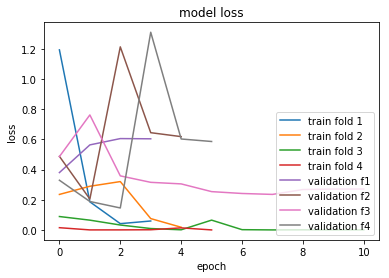

In [16]:
print(f'history keys = {historiesC3[0].history.keys()}')
print(f'len(histories) = {len(histories)}')
# summarize history for accuracy
plt.plot(historiesC3[0].history['acc'])
plt.plot(historiesC3[1].history['acc'])
plt.plot(historiesC3[2].history['acc'])
plt.plot(historiesC3[3].history['acc'])
plt.plot(historiesC3[0].history['val_acc'])
plt.plot(historiesC3[1].history['val_acc'])
plt.plot(historiesC3[2].history['val_acc'])
plt.plot(historiesC3[3].history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train fold 1', 'train fold 2', 'train fold 3', 'train fold 4', 'validation f1', 'validation f2', 'validation f3', 'validation f4'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(historiesC3[0].history['loss'])
plt.plot(historiesC3[1].history['loss'])
plt.plot(historiesC3[2].history['loss'])
plt.plot(historiesC3[3].history['loss'])
plt.plot(historiesC3[0].history['val_loss'])
plt.plot(historiesC3[1].history['val_loss'])
plt.plot(historiesC3[2].history['val_loss'])
plt.plot(historiesC3[3].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train fold 1', 'train fold 2', 'train fold 3', 'train fold 4', 'validation f1', 'validation f2', 'validation f3', 'validation f4'], loc='lower right')
plt.show()

In [18]:
def mobilenet_v2_b(img_dim):
    # base network to be built around:
    base_model = MobileNetV2(input_shape=None,
                             #input_shape=img_dim,
                             alpha=1.0,
                             depth_multiplier=1,
                             include_top=False,
                             weights='imagenet',
                             input_tensor=None,
                             pooling=None
                             #classes=1000
                            )
    #for layer in base_model.layers:
    #    layer.trainable = False
    for layer in base_model.layers[:-3]: # All but ~last three layers
        layer.trainable = False          #  are no trainable.
    for layer in base_model.layers[-3:]: # ~Last three layers
        layer.trainable = True           #  are trainable.

    xi = Input(shape=img_dim)              # input tensor
    x  = BatchNormalization()(xi)          # next layer
    x  = base_model(x)                     # Each x on the right refers to
    x  = Dropout(0.5)(x)                   #  the previous x on the left.
    x  = Flatten()(x)                      #
    xo = Dense(1, activation='sigmoid')(x) # output tensor
    model = Model(inputs=xi, outputs=xo, name='mobilenet_v2_b')
    return model

In [35]:
model = mobilenet_v2_b((224,224,3))
print(model.name)
print(model.summary())

mobilenet_v2_b
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
mobilenetv2_1.00_224 (Model) multiple                  2257984   
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 1280)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 62721     
Total params: 2,320,717
Trainable params: 65,287
Non-trainable params: 2,255,430
______________________________________________

In [36]:
print(len(model.layers))
print(model.layers[2].name)
print(len(model.layers[2].layers))

6
mobilenetv2_1.00_224
155


In [37]:
def xception_a(img_dim):
    # base network to be built around:
    base_model = Xception(input_shape=None,
                          include_top=True,
                          weights='imagenet',
                          input_tensor=None,
                          pooling=None
                          #classes=1000
                         )

    for layer in base_model.layers:
        layer.trainable = False
    #for layer in base_model.layers[:-3]: # All but ~last three layers
    #    layer.trainable = False          #  are no trainable.
    #for layer in base_model.layers[-3:]: # ~Last three layers
    #    layer.trainable = True           #  are trainable.

    xi = Input(shape=img_dim)              # input tensor
    x  = BatchNormalization()(xi)          # next layer
    x  = base_model(x)                     # Each x on the right refers to
    x  = Dropout(0.5)(x)                   #  the previous x on the left.
    x  = Flatten()(x)                      #
    xo = Dense(1, activation='sigmoid')(x) # output tensor
    model = Model(inputs=xi, outputs=xo, name='xception_a')
    return model

In [42]:
modelx = xception_a((576, 576, 3))
print(modelx.name)
print(modelx.summary())

ValueError: Input 0 is incompatible with layer flatten_9: expected min_ndim=3, found ndim=2

In [ ]:
print(len(modelx.layers))
print(modelx.layers[2].name)
print(len(modelx.layers[2].layers))